# TXS 0506+056 with PGammaSpectrum

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
import logging

# Locate the specific logger for hierarchical_nu and set it to WARNING
logger = logging.getLogger('hierarchical_nu')
logger.setLevel(logging.WARNING)

# Also disable propagation of DEBUG messages to root logger
logger.propagate = False

## Source info

In [95]:
# A TXS-like source (see IceCube et al. 2018)
txs_coords = SkyCoord(ra=77.36 * u.deg, dec=5.69 * u.deg, frame="icrs")
txs_z = 0.3365
#txs_Emin = (200 * u.TeV).to(u.GeV)
#txs_Emax = (7.5 * u.PeV).to(u.GeV) 
txs_Emin = (10 * u.TeV).to(u.GeV)
txs_Emax = (1000 * u.PeV).to(u.GeV) 

# An IC170922-like event + nu observations
ic_Edet = (23.7 * u.TeV).to(u.GeV) # IceCube et al. 2018

ic_Emin_det = (20 * u.TeV).to(u.GeV)

#ic_src_index = 2.13 # IceCube et al. 2018 
#ic_L = 2.1e46 
#ic_L = 3e45 * (u.erg/u.s) # Value from ps constraints (flux_norm @ 100 TeV ~ 5e-16 1/(GeVms))
ic_L = 3e46 * (u.erg / u.s) # Nex_src ~ 1
ic_src_index = 2.0

ic_diff_norm = (2e-18 * 4 * np.pi * (1 / (u.GeV * u.cm**2 * u.s))).to(1/(u.GeV * u.m**2 * u.s))
ic_diff_index = 2.6
ic_T = 0.5 * u.year
ic_ang_res = 0.7 * u.deg
ic_ra = 77.43 * u.deg # GCN 21916 (-0.80 deg/+1.30 deg 90% PSF containment)
ic_dec = 5.79 * u.deg # GCN 21916 (-0.40 deg/+0.70 deg 90% PSF containment) 

In [96]:
from hierarchical_nu.source.parameter import Parameter, ParScale
from hierarchical_nu.source.source import Sources, PointSource, DetectorFrame

In [97]:
# define high-level parameters
Parameter.clear_registry()
E0_src = Parameter(1e5 * u.GeV, "E0_src", fixed=False, par_range=(1e3, 1e9)*u.GeV, scale=ParScale.log)
L = Parameter(ic_L, "luminosity", fixed=True, 
              par_range=(0, 1E60) * (u.erg/u.s))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(txs_Emin, "Emin", fixed=True)
Emax = Parameter(txs_Emax, "Emax", fixed=True)
Emin_src = Parameter(Emin.value, "Emin_src", fixed=True)
Emax_src = Parameter(Emax.value, "Emax_src", fixed=True)
Emin_diff = Parameter(Emin.value, "Emin_diff", fixed=True)
Emax_diff = Parameter(Emax.value, "Emax_diff", fixed=True)
print(Emax_src.value)

flux_units = 1/(u.GeV * u.m**2 * u.s)

#Had to add
Emin_det = Parameter(ic_Emin_det, "Emin_det", fixed=True)
diff_index = Parameter(ic_diff_index, "diff_index", fixed=False, par_range=(1, 4))
diffuse_norm = Parameter(ic_diff_norm, "diffuse_norm", fixed=True, par_range=(0, np.inf)*flux_units)

#src_index = Parameter(ic_src_index, "src_index", fixed=False, par_range=(1, 4))

1000000000.0 GeV


In [98]:
from hierarchical_nu.detector.input import mceq

In [99]:
# Define sources
point_source = PointSource.make_pgamma_source(
    "txs", txs_coords.dec.to(u.rad), txs_coords.ra.to(u.rad), L, txs_z, E0_src, Emin_src, Emax_src, DetectorFrame)

my_sources = Sources()
my_sources.add(point_source)

# auto diffuse component 
my_sources.add_diffuse_component(diffuse_norm, Enorm.value, diff_index, Emin_diff, Emax_diff) 
my_sources.add_atmospheric_component(cache_dir=mceq) # auto atmo component

Text(0, 0.5, 'dN/dE [Gev^-1 cm^-2 s^-1]')

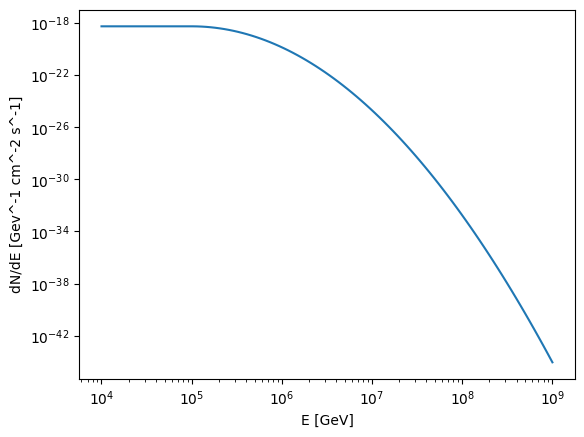

In [8]:
energy_range = np.logspace(np.log10(Emin.value.to(u.GeV).value), np.log10(Emax.value.to(u.GeV).value), 100) * u.GeV

pgamma_spectrum = my_sources.point_source[0].flux_model.spectral_shape

fig, ax = plt.subplots()
ax.plot(energy_range.to_value(u.GeV), pgamma_spectrum(energy_range).to_value(1 / (u.GeV * u.cm**2 * u.s)))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [GeV]")
ax.set_ylabel("dN/dE [Gev^-1 cm^-2 s^-1]")

Text(0, 0.5, 'E^2 dN/dE [Gev^-1 cm^-2 s^-1]')

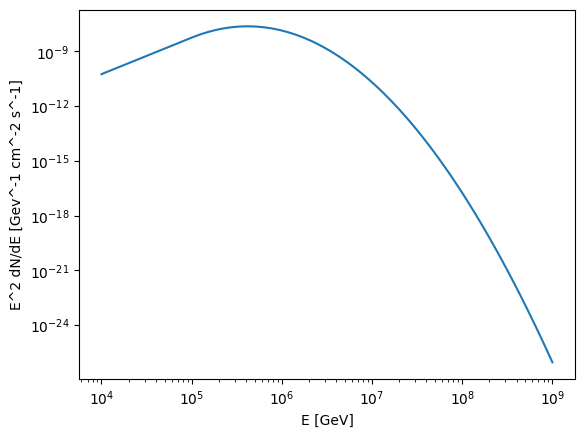

In [9]:
fig, ax = plt.subplots()
ax.plot(energy_range.to_value(u.GeV), energy_range**2 * pgamma_spectrum(energy_range).to_value(1 / (u.GeV * u.cm**2 * u.s)))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [GeV]")
ax.set_ylabel("E^2 dN/dE [Gev^-1 cm^-2 s^-1]")

In [10]:
point_source.flux_model._spectral_shape._parameters["norm"]

Parameter txs_norm = 5.561010756362878e-15 1 / (GeV s m2), fixed = True

In [11]:
my_sources.f_arr() # Associated fraction of arrival flux

<Quantity 0.00017912>

In [12]:
my_sources.f_arr_astro() # As above, excluding atmo

<Quantity 0.00294833>

## ROI

In [13]:
from hierarchical_nu.utils.roi import CircularROI

In [14]:
roi = CircularROI(txs_coords, 5 * u.deg, apply_roi=True)

## Simulation

In [15]:
from hierarchical_nu.simulation import Simulation
from hierarchical_nu.detector.icecube import IC86_II

/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
obs_time = ic_T

sim = Simulation(my_sources, IC86_II, obs_time)
#sim = Simulation(my_sources, IceCubeDetectorModel, obs_time)

In [17]:
sim.precomputation()
sim.generate_stan_code()
#sim.set_stan_filename(".stan_files/sim_code_asimov.stan")
sim.compile_stan_code()

17:49:36 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/sim_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/sim_code
17:49:56 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/caba/examples/.stan_files/sim_code


In [18]:
sim.run(verbose=True, seed=173, show_console=True) 
sim.save("txs_gamma_sim.h5", overwrite=True)
#sim.save("output/test_sim.h5")

17:49:56 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing


Running a simulation with expected Nnu = 2.59 events
Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = fixed_param
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmp27u67rxq/fet2a08x.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 173
Chain [1] output
Chain [1] file = /tmp/tmp27u67rxq/sim_codeu0pgcq67/sim_code-20240920174956.csv
Chain [1] diagnostic_file =  (Default)
Chain [1] refresh = 100 (Default)
Chain [1] sig_figs = -1 (Default)
Chain [1]

PosixPath('/home/iwsatlas1/caba/examples/txs_gamma_sim.h5')

In [19]:
sim._expected_Nnu_per_comp

array([2.34404738, 0.04450764, 0.19806281])

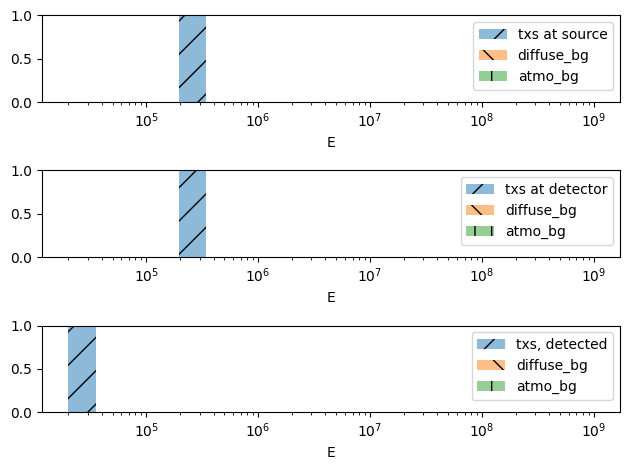

In [20]:
fig, ax = sim.show_spectrum()
fig.tight_layout()

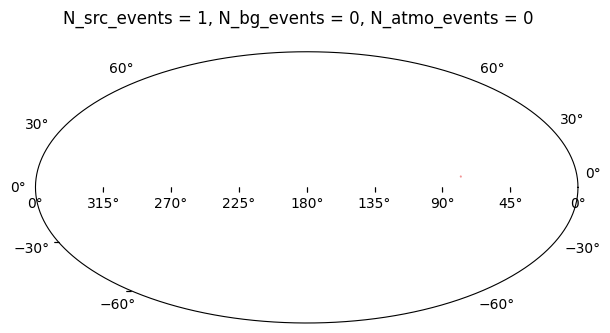

In [21]:
fig, ax = sim.show_skymap()

In [22]:
sim.events.energies

<Quantity [29892.8] GeV>

## Fit

In [23]:
from hierarchical_nu.events import Events
from hierarchical_nu.fit import StanFit
from hierarchical_nu.priors import Priors, LogNormalPrior, NormalPrior, FluxPrior, LuminosityPrior, IndexPrior,DifferentialFluxPrior, EnergyPrior

In [24]:
events = Events.from_file("txs_gamma_sim.h5")
#events = sim.events
obs_time = ic_T

In [131]:
# Different prior means to try

L_prior_mean = 1e49 * (u.GeV / u.s)
L_prior_width = 3

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
#diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
#priors.diffuse_flux = DifferentialFluxPrior(LogNormalPrior, mu=ic_diff_norm, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)
priors.E0_src = EnergyPrior(LogNormalPrior, mu=3.1e7 * u.GeV, sigma=0.1)

In [132]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)
#fit = StanFit(my_sources, IceCubeDetectorModel, events, obs_time, priors=priors, nshards=0)

In [133]:
import time

In [134]:
fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()
start_time = time.time()
fit.run(show_progress=True, show_console=True, seed=9856845, iterations=1000, iter_warmup=1000, chains=4, adapt_delta=0.9)
time_taken = time.time() - start_time

DEBUG:cmdstanpy:Removing /home/iwsatlas1/caba/examples/.stan_files/model_code
18:38:43 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
INFO:cmdstanpy:compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--include-paths=/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/hierarchical_nu/stan,/home/iwsatlas1/caba/examples/.stan_files STAN_THREADS=True /home/iwsatlas1/caba/examples/.stan_files/model_code
cwd: /home/iwsatlas1/caba/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/hierarchical_nu/stan,/home/iwsatlas1/caba/examples/.stan_files --o=/home/iwsatlas1/caba/examples/.stan_files/mo

method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.9
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /tmp/tmp27u67rxq/i3crme7u.json
init = 2 (Default)
random
seed = 9856845
output
file = /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (Default)


Gradient evaluation took 0.000117 seconds
1000 transitions using 10 leapfrog steps 

18:39:13 - cmdstanpy - INFO - CmdStan done processing
INFO:cmdstanpy:CmdStan done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=1
 cmd (chain 1):
	['/home/iwsatlas1/caba/examples/.stan_files/model_code', 'id=1', 'random', 'seed=9856845', 'data', 'file=/tmp/tmp27u67rxq/i3crme7u.json', 'output', 'file=/tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9', 'num_chains=4']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_1.csv
 console_msgs (if any):
	/tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (D

Chain [1] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [1] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 1.12 seconds (Warm-up)
0.725 seconds (Sampling)
1.845 seconds (Total)




In [135]:
time_taken

1.9408655166625977

In [136]:
fit._fit_output.diagnose()

DEBUG:cmdstanpy:cmd: /home/iwsatlas1/caba/.cmdstan/cmdstan-2.35.0/bin/diagnose /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_1.csv /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_2.csv /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_3.csv /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_4.csv
cwd: None


'Processing csv files: /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_1.csv, /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_2.csv, /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_3.csv, /tmp/tmp27u67rxq/model_code5bkaa86b/model_code-20240920183911_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nThe E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.\nIf possible, try to reparameterize the model.\n\nThe following parameters had fewer than 0.001 effective draws per transition:\n  L, E0_src, diffuse_norm, diff_index, F_atmo, Nex, Nex_comp[1], Nex_atmo, Nex_atmo_comp[1], L_ind[1], E0_src_ind[1], Nex_src, Nex_src_comp[1], Nex_per_ps[1], F_diff, Nex_diff, Nex_diff_comp[1], Ftot, Fs, f

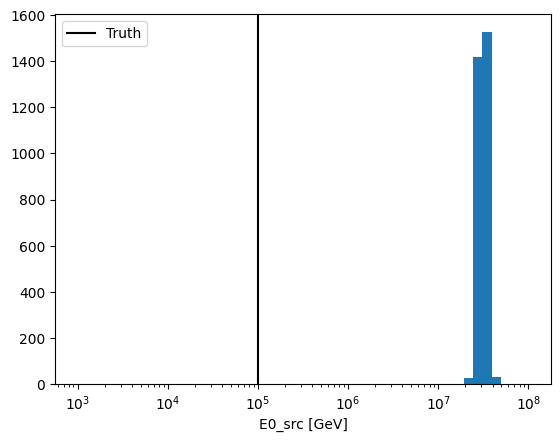

In [137]:
#fit.plot_trace()
#fig.tight_layout()

from hierarchical_nu.simulation import SimInfo
sim_info = SimInfo.from_file("txs_gamma_sim.h5")

Ebins = np.geomspace(1e3, 1e8)

fig, ax = plt.subplots()
ax.hist(fit._fit_output.stan_variable("E0_src"), bins=Ebins)
ax.axvline(sim_info.inputs["E0_src"], color="k", label="Truth")
ax.set_xscale("log")
ax.set_xlabel("E0_src [GeV]")
ax.legend();

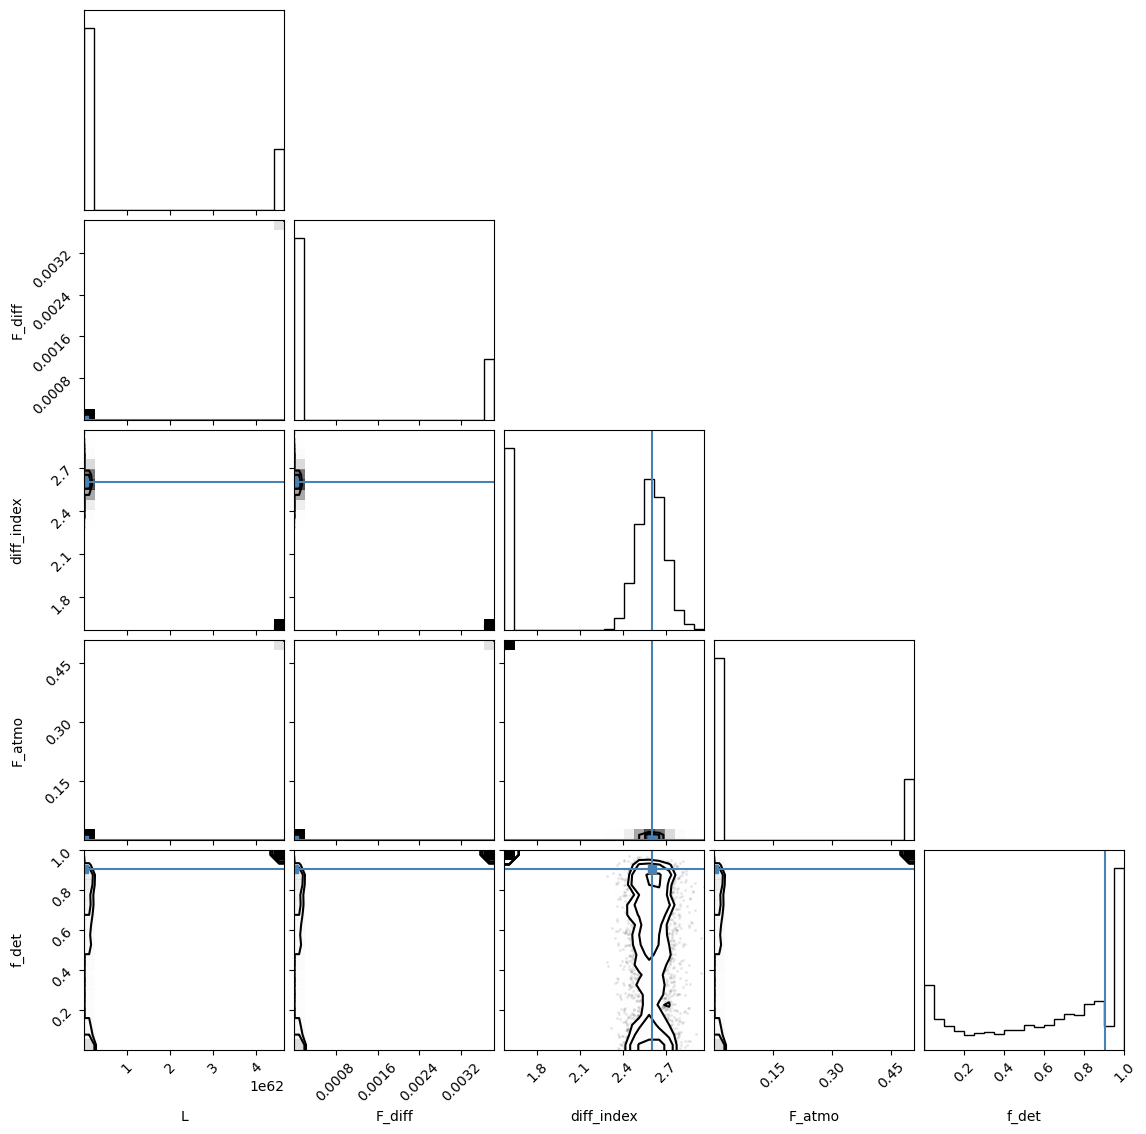

In [138]:
sim_info = SimInfo.from_file("txs_gamma_sim.h5")
fig = fit.corner_plot(var_names=["L", "F_diff", "diff_index", "F_atmo", "f_det"], truths=sim_info.truths)

#print(sim_info.truths.keys())  # Check if 'E0_src' is present

In [139]:
_ = fit.check_classification(sim_info.outputs)

All events are correctly classified


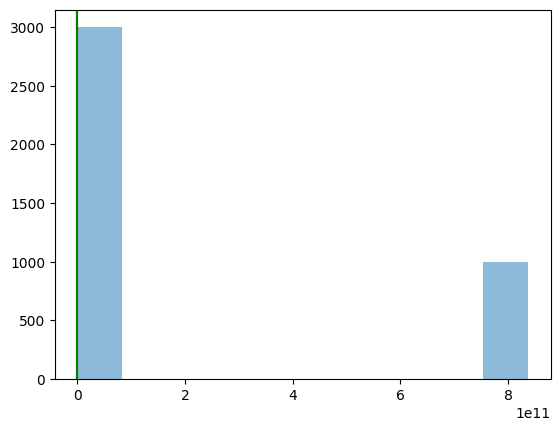

In [140]:
fig, ax = plt.subplots()
ax.hist(fit._fit_output.stan_variable("Nex_src"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_diff"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_atmo"), alpha=0.5)
ax.axvline(sim._expected_Nnu_per_comp[0], color="blue")
ax.axvline(sim._expected_Nnu_per_comp[1], color="orange")
ax.axvline(sim._expected_Nnu_per_comp[2], color="green")

## Fit with similar reconstructed event

In [37]:
from icecube_tools.utils.vMF import get_kappa

In [38]:
sim_info = SimInfo.from_file("txs_gamma_sim.h5")
events = Events.from_file("txs_gamma_sim.h5")

obs_time = ic_T

labels = sim_info.outputs["Lambda"] - 1
source = np.where(labels==0)[0]
if len(source) != 1:
    print("There is not 1 source event in this event list!")

In [39]:
# IC170922A-like values 
events.energies[source] = ic_Edet
events.ang_errs[source] = 0.7 * u.deg
events.kappas[source] = get_kappa(ic_ang_res.to_value(u.deg), p=0.683)

ic_coord = SkyCoord(ra=ic_ra, dec=ic_dec, distance=1, frame="icrs")
ic_coord.representation_type = "cartesian"
new_coord = SkyCoord(x=ic_coord.x, y=ic_coord.y, z=ic_coord.z, frame="icrs", representation_type="cartesian")
events.coords[source] = new_coord
events.unit_vectors[source][:] = np.array([ic_coord.x, ic_coord.y, ic_coord.z])

"""
rm_idx = np.where(events.energies==np.max(events.energies[labels==1]))[0].squeeze()
labels = np.delete(labels, rm_idx)
events.remove(rm_idx)
"""

events.to_file("txs_gamma_ev.h5")

In [40]:
events = Events.from_file("txs_gamma_ev.h5")

In [114]:
# Different prior means to try

L_prior_mean = 1e49 * (u.GeV / u.s)
L_prior_width = 3

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
#diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
#priors.diffuse_flux = DifferentialFluxPrior(LogNormalPrior, mu=ic_diff_norm, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)
priors.E0_src = EnergyPrior(LogNormalPrior, mu=3.1e7 * u.GeV, sigma=0.1)

In [115]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)

fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()

fit.run(show_progress=True, show_console=True, seed=1, iterations=1000, iter_warmup=1000, chains=4, adapt_delta=0.9)

DEBUG:cmdstanpy:Removing /home/iwsatlas1/caba/examples/.stan_files/model_code
18:20:32 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
INFO:cmdstanpy:compiling stan file /home/iwsatlas1/caba/examples/.stan_files/model_code.stan to exe file /home/iwsatlas1/caba/examples/.stan_files/model_code
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--include-paths=/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/hierarchical_nu/stan,/home/iwsatlas1/caba/examples/.stan_files STAN_THREADS=True /home/iwsatlas1/caba/examples/.stan_files/model_code
cwd: /home/iwsatlas1/caba/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/iwsatlas1/caba/miniconda3/envs/hnu/lib/python3.11/site-packages/hierarchical_nu/stan,/home/iwsatlas1/caba/examples/.stan_files --o=/home/iwsatlas1/caba/examples/.stan_files/mo

method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.9
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /tmp/tmp27u67rxq/r5369dkr.json
init = 2 (Default)
random
seed = 1
output
file = /tmp/tmp27u67rxq/model_codelytclr20/model_code-20240920182059.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (Default)


Gradient evaluation took 0.000113 seconds
1000 transitions using 10 leapfrog steps per tr

18:21:01 - cmdstanpy - INFO - CmdStan done processing
INFO:cmdstanpy:CmdStan done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=1
 cmd (chain 1):
	['/home/iwsatlas1/caba/examples/.stan_files/model_code', 'id=1', 'random', 'seed=1', 'data', 'file=/tmp/tmp27u67rxq/r5369dkr.json', 'output', 'file=/tmp/tmp27u67rxq/model_codelytclr20/model_code-20240920182059.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9', 'num_chains=4']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp27u67rxq/model_codelytclr20/model_code-20240920182059_1.csv
 console_msgs (if any):
	/tmp/tmp27u67rxq/model_codelytclr20/model_code-20240920182059-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default

Chain [3] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)

Elapsed Time: 0.671 seconds (Warm-up)
0.885 seconds (Sampling)
1.556 seconds (Total)

























(<Figure size 1200x1400 with 14 Axes>,
 array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
        [<Axes: title={'center': 'E0_src'}>,
         <Axes: title={'center': 'E0_src'}>],
        [<Axes: title={'center': 'diffuse_norm'}>,
         <Axes: title={'center': 'diffuse_norm'}>],
        [<Axes: title={'center': 'diff_index'}>,
         <Axes: title={'center': 'diff_index'}>],
        [<Axes: title={'center': 'F_atmo'}>,
         <Axes: title={'center': 'F_atmo'}>],
        [<Axes: title={'center': 'f_arr'}>,
         <Axes: title={'center': 'f_arr'}>],
        [<Axes: title={'center': 'f_det'}>,
         <Axes: title={'center': 'f_det'}>]], dtype=object))

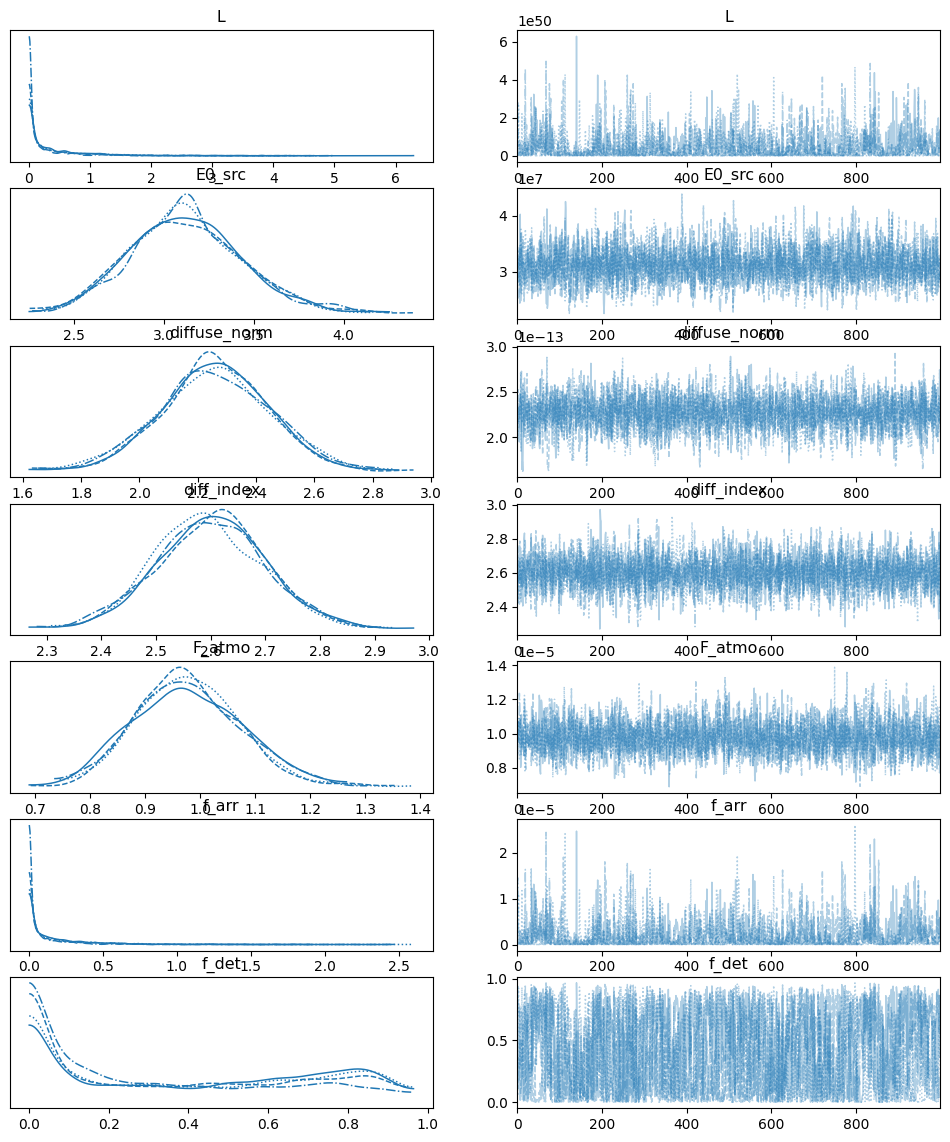

In [116]:
fit.plot_trace()

In [117]:
#sim_info = SimInfo.from_file("txs_gamma_ev.h5")
#fig = fit.corner_plot()

In [118]:
# Check association probability
prob_each_src = np.array(fit._get_event_classifications())
p_src = prob_each_src[source].squeeze()[0]
print("Assoc. prob = %.5f" % p_src)
#prob_each_src

Assoc. prob = 0.41536


In [119]:
prob_each_src

array([[0.41536463, 0.06370467, 0.5209307 ]])

(<Figure size 1200x450 with 3 Axes>,
 [<AstroDegreesZoomAxes: >,
  <Axes: xlabel='$E~[\\mathrm{GeV}]$', ylabel='posterior pdf'>])

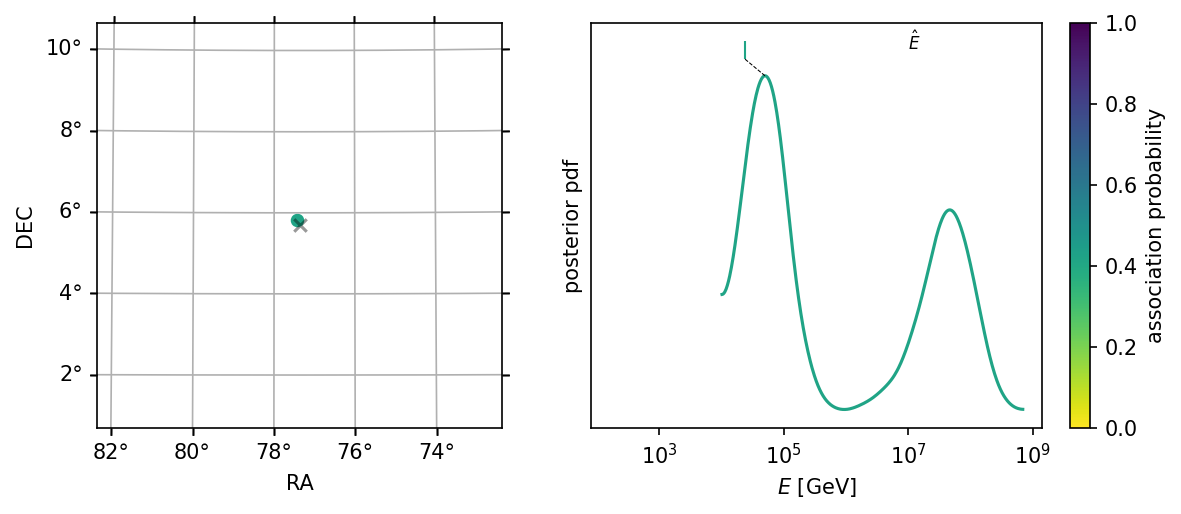

In [120]:
fit.plot_energy_and_roi()